This notebook will walk through the reason that it is necessary to model response times, and the various ways to model them. We will start by generating a design that has trials that vary in reaction time.  This is adapted from Poldrack (2014, Developmental Cognitive Neuroscience).

In [15]:
import numpy
import nibabel
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.nonparametric.smoothers_lowess
import scipy
import nipype.algorithms.modelgen as model   # model generation
from nipype.interfaces.base import Bunch
from  nipype.interfaces import fsl
from statsmodels.tsa.arima_process import arma_generate_sample
import os,shutil

from nipype.caching import Memory
mem = Memory(base_dir='.')

def clearmem():
    for root, dirs, files in os.walk(mem.base_dir):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))
    
# generate the design at a higher temporal resolution
tr=0.1


First generate a design with four events that differ in their duration (by turning on the function for inreasing amounts of time).

In [16]:
variable_sf=numpy.zeros(1000)

variable_sf[100:102]=1
variable_sf[300:303]=1
variable_sf[500:505]=1
variable_sf[700:706]=1
variable_sf_conv=numpy.convolve(variable_sf,
                                spm_hrf(tr,oversampling=1))[0:len(variable_sf)]

Generate a beta-series design matrix that fits a separate regressor for each of the four trials; this is equivalent to separately modeling the intensity of each trial (assuming a constant duration for each).

In [17]:
hrf_bases=numpy.zeros((1000,4))
hrf_bases[100:104,0]=1
hrf_bases[300:304,1]=1
hrf_bases[500:504,2]=1
hrf_bases[700:704,3]=1
desmtx=numpy.zeros((1000,4))

for x in range(4):
    desmtx[:,x]=numpy.convolve(hrf_bases[:,x],
                               spm_hrf(tr,oversampling=1))[0:len(variable_sf)]

Now fit the beta-series model, and generate the fitted regressor.

In [18]:
b_est=numpy.linalg.inv(desmtx.T.dot(desmtx)).dot(desmtx.T).dot(variable_sf_conv)

intensity_sf_conv=desmtx.dot(b_est)

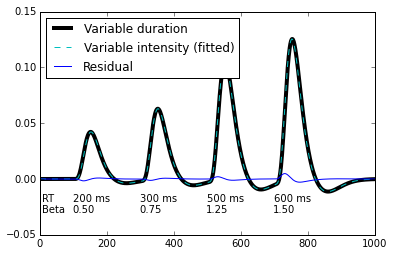

In [19]:
plt.clf()
plt.plot(variable_sf_conv,color='k',linewidth=4)
plt.hold(True)
plt.plot(intensity_sf_conv,'c--')
#plt.plot(constant_sf_conv,color='b')
plt.plot(intensity_sf_conv - variable_sf_conv,color='b')
plt.text(10,-0.02,'RT')
plt.text(100,-0.02,'200 ms')
plt.text(300,-0.02,'300 ms')
plt.text(500,-0.02,'500 ms')
plt.text(700,-0.02,'600 ms')
plt.text(10,-0.03,'Beta')
plt.text(100,-0.03,'%0.2f'%b_est[0])
plt.text(300,-0.03,'%0.2f'%b_est[1])
plt.text(500,-0.03,'%0.2f'%b_est[2])
plt.text(700,-0.03,'%0.2f'%b_est[3])

plt.axis([0,1000,-0.05,0.15])
plt.legend(['Variable duration','Variable intensity (fitted)','Residual'],
           loc='upper left')

Now let's look at the various ways that one can model response times. First let's generate a design with two conditions that differ in mean response times. We will use a lognormal distribution which is a reasonable approximation to the shape of RT distributions.

Mean RT (condition 0): 1.00025364852
Mean RT (condition 1): 2.15208003357


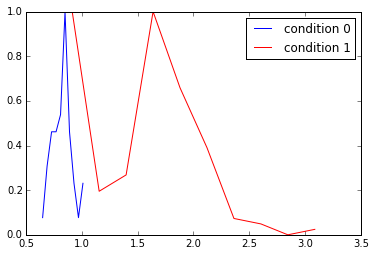

In [20]:
diff=0.5 # difference in RT across conditions
ntrials=100 #  trials per condition
condition=numpy.zeros(ntrials)
condition[ntrials/2:]=1 
rt=numpy.hstack((numpy.random.lognormal(0.0,0.2,ntrials),
                numpy.random.lognormal(diff,0.2,ntrials)))
#rt[:ntrials/2]+=rtdiff
h1=numpy.histogram(rt[:ntrials/2])
plt.plot((h1[1][1:]+h1[1][:1])/2.0,h1[0]/float(numpy.max(h1[0])))
h2=numpy.histogram(rt[ntrials/2:])
plt.plot((h2[1][1:]+h2[1][:1])/2.0,h2[0]/float(numpy.max(h2[0])),color='red')
print 'Mean RT (condition 0):',numpy.mean(rt[:ntrials/2])
print 'Mean RT (condition 1):',numpy.mean(rt[ntrials/2:])
plt.legend(['condition 0','condition 1'])
meanrt=numpy.mean(rt)

# generate random onsets

trial_length=6 # length of each trial, including ISI
total_length=trial_length*ntrials
randonsets=numpy.arange(0,total_length,trial_length)
onsets=numpy.zeros(len(randonsets))
onsets[:ntrials/2]=numpy.sort(randonsets[:ntrials/2])
onsets[ntrials/2:]=numpy.sort(randonsets[ntrials/2:])

numpy.random.shuffle(onsets)


Use the model generation tools from nipype/fsl to generate the design matrix.

In [21]:
info = [Bunch(conditions=['cond0',
                          'cond1'],
              onsets=[onsets[condition==0],
                      onsets[condition==1]],
              durations=[rt[condition==0],
                         rt[condition==1]])]

# create a dummy image for SpecifyModel to look at
dummy=nibabel.Nifti1Image(numpy.zeros((12,12,12,total_length)),numpy.identity(4))
dummy.to_filename('tmp.nii.gz')
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

INFO:workflow:Executing node 6bd9ff7dd7eaaef1c0850f6b354518bc in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/6bd9ff7dd7eaaef1c0850f6b354518bc
INFO:workflow:Executing node 84d03b112fcd7e8db76719fdfd1b4851 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/84d03b112fcd7e8db76719fdfd1b4851
INFO:workflow:Running: feat_model run0 



con_file = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/84d03b112fcd7e8db76719fdfd1b4851/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/84d03b112fcd7e8db76719fdfd1b4851/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/84d03b112fcd7e8db76719fdfd1b4851/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/84d03b112fcd7e8db76719fdfd1b4851/run0.png
fcon_file = <undefined>

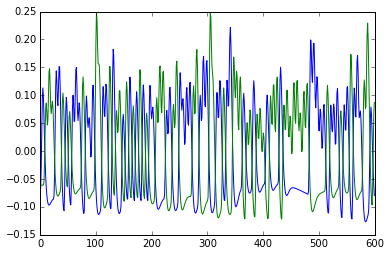

In [22]:
X=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.plot(X)

In [23]:
data=X.dot([1,1]) + arma_generate_sample([1,0.4],[1,0.],X.shape[0])*0.01
beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data)
print beta_hat

[ 1.00871038  1.00834889]


Now let's build a model that does not take into account the different durations.

In [24]:
info = [Bunch(conditions=['cond0',
                          'cond1'],
              onsets=[numpy.sort(onsets[condition==0]),
                      numpy.sort(onsets[condition==1])],
              durations=[[meanrt],
                         [meanrt]])]

# create a dummy image for SpecifyModel to look at
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = 'tmp.nii.gz'
s.inputs.time_repetition = 1.0
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()

clearmem()

level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1.0,
                                    bases = {'dgamma':{'derivs': False}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=False)

modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

INFO:workflow:Executing node 0c6ca00748a4814b604aa963a99a4987 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0c6ca00748a4814b604aa963a99a4987
INFO:workflow:Executing node 3a329057ed7eb051ce90af45718dbe13 in dir: /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/3a329057ed7eb051ce90af45718dbe13
INFO:workflow:Running: feat_model run0 



con_file = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/3a329057ed7eb051ce90af45718dbe13/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/3a329057ed7eb051ce90af45718dbe13/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/3a329057ed7eb051ce90af45718dbe13/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem/nipype-interfaces-fsl-model-FEATModel/3a329057ed7eb051ce90af45718dbe13/run0.png
fcon_file = <undefined>

In [25]:
X_constantdur=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
beta_hat_constantdur=numpy.linalg.inv(X_constantdur.T.dot(X_constantdur)).dot(X_constantdur.T).dot(data)
print beta_hat_constantdur

[ 0.50989163  0.51324401]


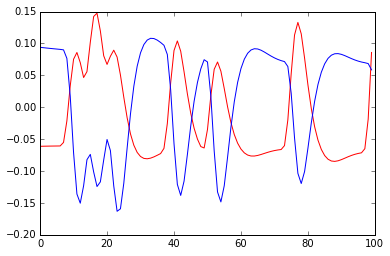

In [26]:
plt.plot(X[:100,1],color='r')
plt.plot(X[:100,1] - X_constantdur[:100,1])

In [27]:
mem.cache


<bound method Memory.cache of Memory(base_dir=/home/vagrant/fmri-analysis-vm/analysis/RTmodeling/nipype_mem)>